# DeeSOM: Getting started
This is a brief demo where a deeSOM model is trained and tested with real genome-wide data.  

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from shutil import unpack_archive
from random import shuffle, seed
from scipy.stats import zscore

import pandas as pd
from sklearn.metrics import precision_recall_curve
from deesom import DeeSOM
from sklearn.manifold import TSNE

# Reproducibility
seed(1)
np.random.seed(1)

In [23]:
def gen_partitions(fname, part=.2, mode="transductive"):
    """
    Load dataset and generate train/test partitions.
    :param fname: Dataset to load in format .csv. Has M features and labels under the name "CLASS" and sequence names under "sequence_names".
    :param part: Proportion of test samples
    :param mode: Can be either "transductive" (train with all data but only training labels) or "inductive" (train with some data, predict on unseen data) 
    :return: train_data: dataset with a 20% of positives labeled as 0 (unlabeled). test_labels contains the real labels
    to test how many true-positives are finally retrieved.
    """
    data = pd.read_csv(fname)
    labels = data.CLASS.values
    data = data.drop(columns=["sequence_names", "CLASS"]).values
       
    # Feature normalization 
    data = zscore(data, axis=0)

    pos_ind = np.where(labels == 1)[0]
    shuffle(pos_ind)
    
    if mode=="transductive":
        test_labels = labels.copy()
        train_data = data
        train_labels = labels
        P = len(pos_ind)
        train_labels[pos_ind[:int(P * part)]] = 0 # hidding positive labels for testing

        return train_data, train_labels, test_labels
    
    if mode=="inductive":
        
        ind = np.arange(data.shape[0])
        np.random.shuffle(ind)
        
        p = int(len(ind) * part)
        test_data = data[ind[:p], :]
        train_data = data[ind[p:], :]
        
        test_labels = labels[ind[:p]]
        train_labels = labels[ind[p:]]
        
        return train_data, train_labels, test_data, test_labels

### Download data
We will use the features of more than 1.3M secuences than could be micro-RNAs. Some of them are tagged as _positive_ (1), and the others are _unknown_ (0). More details can be found in:

>Genome-wide hairpins datasets of animals and plants for novel miRNA prediction, L. A. Bugnon, C. Yones, J. Raad, D. H. Milone, G. Stegmayer, Data in Brief (in press), 2019



In [24]:
#!wget -O "ath.zip" https://sourceforge.net/projects/sourcesinc/files/mirdata/features/ath.zip/download 
#unpack_archive('ath.zip', 'data/')

# Generate train and test partitions, simplily removing a 20% of positives. 
train_data, train_labels, test_labels = gen_partitions("data/ath.csv")

print("Data is composed of %d samples, where %d are well-known micro-RNAs (positives). %d positive samples are marked as unknown for testing" % 
     (len(train_labels), sum(test_labels), sum(test_labels)-sum(train_labels)))

Data is composed of 1355663 samples, where 304 are well-known micro-RNAs (positives). 60 positive samples are marked as unknown for testing


### Training the model
DeeSOM uses the scikit-learn API, thus can be combined in any processing pipeline. Hyperparameters are described in the documentation, but defaults values will do for many cases. After creating an instance, the model is trained with the method fit()

In [25]:
# Init
deesom = DeeSOM(verbosity=True)
# Train
deesom.fit(train_data, train_labels)


Start training: n_samples=1355663, n_positives=244
ensemble_member=0_000 	 layer_size=071 	 n_inputs=339098 	 n_outputs=076196 	 (layer_time=3.1 min)
ensemble_member=0_001 	 layer_size=071 	 n_inputs=339099 	 n_outputs=075475 	 (layer_time=6.0 min)
ensemble_member=0_002 	 layer_size=071 	 n_inputs=339099 	 n_outputs=075667 	 (layer_time=9.0 min)
ensemble_member=0_003 	 layer_size=071 	 n_inputs=339099 	 n_outputs=072030 	 (layer_time=12.1 min)
ensemble_layer=0, n_inputs=1355663, n_outputs=298636, (htime=12.1 min)
Layer=001 	 layer_size=068 	 n_inputs=298636 	 n_outputs=070684 	 (layer_time=2.5 min)
Layer=002 	 layer_size=046 	 n_inputs=070684 	 n_outputs=019584 	 (layer_time=0.4 min)
Layer=003 	 layer_size=032 	 n_inputs=019584 	 n_outputs=011226 	 (layer_time=0.1 min)
Layer=004 	 layer_size=028 	 n_inputs=011226 	 n_outputs=008289 	 (layer_time=0.0 min)
Layer=005 	 layer_size=025 	 n_inputs=008289 	 n_outputs=006987 	 (layer_time=0.0 min)
Layer=006 	 layer_size=024 	 n_inputs=006987 

<IPython.core.display.Javascript object>


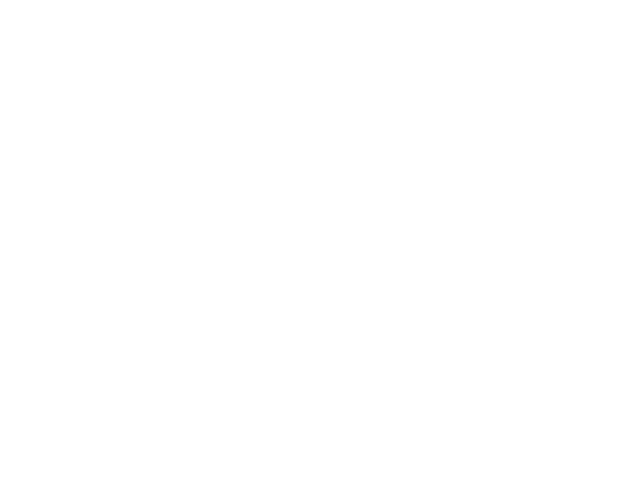

In [26]:
%matplotlib notebook
# In a transductive approach, data is considered as one-class partially labeled. This is, samples can be either
# positive or unknown. predict_proba gives the score for all samples, labeled and unlabeled.
score = deesom.predict_proba()

ind = np.argsort(score)

H = max(score)
plt.plot(score[ind], label="score")
plt.plot(train_labels[ind]*H, 'o', label="train_labels")
plt.plot(test_labels[ind]*H, '*', label="train+test_labels")
plt.legend()
plt.show()


(1060, 2) (1060,)


<IPython.core.display.Javascript object>


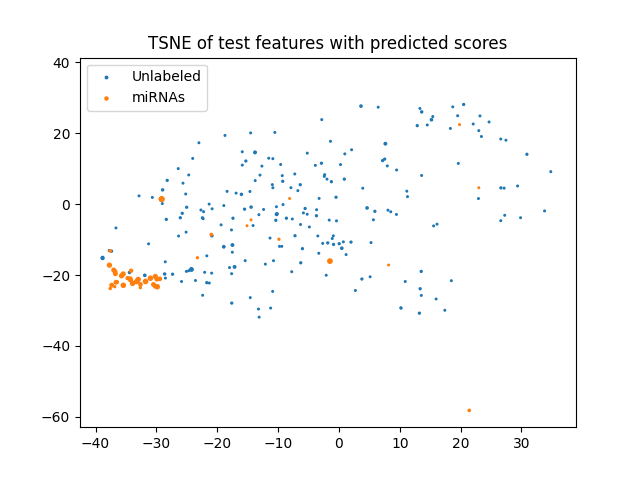

In [27]:
pos_ind = np.where((test_labels == 1) & (train_labels == 0))[0] # only test positives
neg_ind = np.random.choice(np.where(test_labels == 0)[0], 1000)

proy = TSNE().fit_transform(train_data[np.concatenate([pos_ind, neg_ind]),:])

proy_score = score[np.concatenate([pos_ind, neg_ind])]
print(proy.shape, proy_score.shape)

%matplotlib notebook
npos = len(pos_ind)
plt.scatter(proy[npos:, 0], proy[npos:, 1], s=np.sqrt(100*proy_score[npos:]), label="Unlabeled") 
plt.scatter(proy[:npos, 0], proy[:npos, 1], s=np.sqrt(100*proy_score[:npos]), label="miRNAs")
plt.legend()
plt.title("TSNE of test features with predicted scores")
plt.show()

### Prediction on unseen data

In [28]:
# Metrics can be drawn from comparing the score and labels. As dataset is highly imbalanced, precision-recall curve is
# used.
from sklearn.svm import OneClassSVM
train_data, train_labels, test_data, test_labels = gen_partitions("data/ath.csv", mode="inductive")

print("Predict for npos=", np.sum(test_labels), ", nseq=", len(test_labels))

ocsvm = OneClassSVM(kernel="linear")
ocsvm.fit(train_data[train_labels == 1, :])
score_svm = ocsvm.predict(test_data)
presvm, recsvm, _ = precision_recall_curve(test_labels, score_svm)

score = deesom.predict_proba(test_data)
pre, rec, _ = precision_recall_curve(test_labels, score)

Predict for npos= 64 , nseq= 271132


<IPython.core.display.Javascript object>


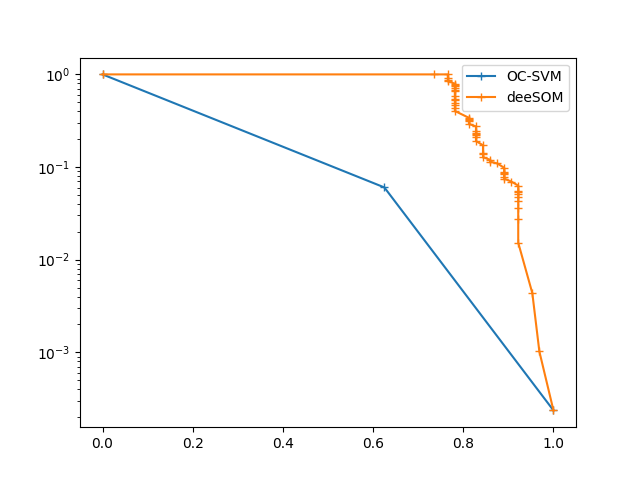

In [29]:
plt.figure()
plt.plot(recsvm, presvm, '+-', label="OC-SVM")
plt.plot(rec, pre, '+-', label="deeSOM")
plt.legend()
plt.yscale("log")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()
